In [ ]:
#using python 3.8.8

In [129]:
import json
import requests
import pandas as pd
import numpy as np
import urllib.request
from urllib.error import HTTPError #used in our try/catch statements to pick up on '429 Too Many Requests'
from time import sleep
import textwrap
import itertools
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
#nltk.downloads('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stopwords_eng = set(stopwords.words("english"))
snowball = SnowballStemmer(language="english")
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Builds a dictionary of features and transforms documents to feature vectors and convert our text documents to a
# matrix of token counts (CountVectorizer)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import warnings #used to suppress "future depreciation of variable messages clogging up the screen"
warnings.filterwarnings("ignore")



In [130]:
stopwords_eng

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [131]:
#----------------
#general
#----------------
#name of output file after merging google,trove, and provided input data together
base_export = r'base_df_export.csv'  
seed = 800 #used as the seed when splitting datasets later

#----------------
#TROVE specific
#----------------

trove_base_url = 'https://api.trove.nla.gov.au/v2/'
trove_api_url = trove_base_url + 'result/'
ISBN_trove_returned = []
trove_api_key ='au6liubdfgg1e4ad'

#name of export/import Trove file
trove_filename = r'trove_api_export.csv'  
#column headings in Trove file
trove_fields = ['ISBN', 't_title', 't_subject', 't_year','t_relevancy_score','t_relevancy_value','t_comments'] 

trove_params_work = {
    'include' : 'articletext,tags=comments,workversions,summary,subject',
    'reclevel' : 'full',
    'key': trove_api_key,
    'encoding':'json'}



#----------------
#GOOGLE specific
#----------------
book_api = "https://developers.google.com/books"
base_api_link = "https://www.googleapis.com/books/v1/volumes?q=isbn:"
ISBN_google_returned = []

#name of export/import Google file
google_filename = 'google_api_export.csv'  
#column headings in Google file
google_fields = ['ISBN', 'g_title', 'g_subtitle','g_category', 'g_maturityRating','g_snippet'] 




In [132]:
#import provided ISBN data
school_book_import = pd.read_csv (r'D:\Uni\MA5851_Masterclass\Assessment 1 - NLP Recommendation Engine\MA5851_SP84_2022_A1_Data.csv')

#convert ISBN to string
school_book_import['ISBN'] = school_book_import['ISBN'].astype("string")

#convert subject to uppercase
school_book_import['Subject'] = school_book_import['Subject'].str.upper()

#there are duplicate ISBNS as multiple schools may use the same book
#to reduce unnecessary API calls we will only need distinct ISBNs
distinct_isbn = school_book_import['ISBN'].unique()



In [133]:
school_book_import

,School_ID,State,Year,Subject,ISBN
0,8,VIC,0,ENGLISH,9781741250879
1,9,NSW,0,ENGLISH,9780648237327
2,15,NSW,0,ENGLISH,9781742990682
3,15,NSW,0,ENGLISH,9781741351750
4,15,NSW,0,ENGLISH,9781742152196
...,...,...,...,...,...
1799,2,VIC,12,ACCOUNTING,9781108688772
1800,2,VIC,12,ACCOUNTING,9781108469913
1801,19,VIC,12,ACCOUNTING,9781108688772
1802,1,NSW,12,LANGUAGES,9781568364575


In [134]:
#print(school_book_import['Subject'].unique())

In [135]:
#function to lookup isbns in trove

ISBN_trove_returned = []

def trove_isbn_lookup(isbn):
    trove_params_isbn = {
        'q': str(isbn), 
        'zone': 'book',
        'isbn' : str(isbn),
        'key' : trove_api_key,
        'encoding' : 'json',
        'n' : 1,
        'include' : 'subject,abstract',
        'reclevel' : 'brief'
    }
    isbn = isbn
    print("Trying: "+str(isbn))

    #send a request to api with individual ISBN as search criteria
    response = requests.get(trove_api_url, params=trove_params_isbn)
    #assign response to variable
    trove_resp = response.json()
    #parse response to extract work id - an alternate 
    
    try:
        #extract work id - alternate key to isbn 
        trove_work_id = trove_resp["response"]["zone"][0]["records"]["work"][0]["id"]
        #concatenate work id to Trove API URL to lookup the item
        api_trove_work_id = trove_base_url + 'work/' + trove_work_id + '?'
        #assign API response to variable
        response = requests.get(api_trove_work_id, params=trove_params_work)
        #format API response into .json format
        full_resp = response.json()
        
        subject = ''
        subject = trove_subject(full_resp,isbn)
        title = trove_title(trove_resp,isbn)
        relevancy_score = trove_rlvcny_scr(trove_resp,isbn)
        relevancy_value = trove_rlvcny_vl(trove_resp,isbn)
        year = trove_year(trove_resp,isbn)
        comments = trove_comments(full_resp,isbn)

        trove_isbn_list = [isbn,title,subject,year,relevancy_score,relevancy_value,comments]
        ISBN_trove_returned.append(trove_isbn_list)

    except KeyError:
        print("no work ID -- can't lookup comments/subject ")
        subject = ''        
        comments = ''   
        title = trove_title(trove_resp,isbn)
        relevancy_score = trove_rlvcny_scr(trove_resp,isbn)
        relevancy_value = trove_rlvcny_vl(trove_resp,isbn)
        year = trove_year(trove_resp,isbn)

        trove_isbn_list = [isbn,title,subject,year,relevancy_score,relevancy_value,comments]
        ISBN_trove_returned.append(trove_isbn_list)

    return ISBN_trove_returned


def trove_title(obj,isbn_inner):
    try:
        title = obj["response"]["zone"][0]["records"]["work"][0]["title"]
        print(title)
    except KeyError:
        print("no title for "+str(isbn_inner))
        title = ''
    return title

def trove_year(obj,isbn_inner):
    try:
        year = str(obj["response"]["zone"][0]["records"]["work"][0]["issued"])
    except KeyError:
        print("no year for "+str(isbn_inner))
        year = ''
    return year

def trove_rlvcny_vl(obj,isbn_inner):
    try:            
        relevancy_value = obj["response"]["zone"][0]["records"]["work"][0]["relevance"]["value"]
    except KeyError:
        print("no relevancy_value for "+str(isbn_inner))
        relevancy_value = ''        
    return relevancy_value

def trove_rlvcny_scr(obj,isbn_inner):
    try:        
        relevancy_score = obj["response"]["zone"][0]["records"]["work"][0]["relevance"]["score"]
    except KeyError:
        print("no relevancy_score for "+str(isbn_inner))
        relevancy_score = ''  
    return relevancy_score

def trove_comments(obj,isbn_inner):
    try:        
        comments = obj["work"]["version"][0]["tagCount"]["value"]
    except KeyError:    
        print("no comments for "+str(isbn_inner))
        comments = ''   
    return comments

def trove_subject(obj,isbn_inner):
    subject = ''
    try:    
        subject0 = ''.join(obj["work"]["subject"]) #converts list to str
        subject1 = ''.join(obj["work"]["version"][0]["record"]["subject"]) #more detailed description
        if subject0[0:10] == subject1[0:30]: #if the start of the strings match then take the longest desc
            if len(subject0) >= len(subject1):
                subject = subject0
            else:
                subject = subject1
        else:
            subject  = subject0 + subject1
    except KeyError:    
        print("no subject for "+str(isbn_inner))
        subject = ''           
    except TypeError:
        try:
            subject0 = ''.join(obj["work"]["subject"]) #converts list to str
        except:
            subject = ''
    except:
        subject = ''
    return subject    

In [136]:
#run the selected ISBNs through the Trove API
def call_trove(lookup_list):
    for i in lookup_list:
        ISBN_trove_returned = trove_isbn_lookup(i)
        sleep(1)
    return ISBN_trove_returned
    print("Finished exporting Trove!")    

In [137]:
#export google/trove data so we don't have to rerun the api calls each time and instead use the previously exported data
def export_file(data,columns,filename):
    with open(filename, 'w',encoding='utf-8',newline='') as f:
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerow(columns)
        write.writerows(data)
    

In [138]:
try: #if trove data has already been saved to computer then import that and use that 
    print("trying to import Trove data")
    trove_data = pd.read_csv(trove_filename)
    print("import successful")
except FileNotFoundError:
    print("can't import, will produce file")
    try: #if doesn't exist in env or computer, then run api calls and export it for next time
        ISBN_trove_returned = call_trove(distinct_isbn) #
        export_file(ISBN_trove_returned,trove_fields,trove_filename) #now export the Trove API data to a csv
        print("exported data - now importing")
        trove_data = pd.read_csv(trove_filename)
    except:
        print("beats me, you're on your own")

# pd.DataFrame(ISBN_trove_returned, columns = trove_fields)            

trying to import Trove data
import successful


In [139]:
trove_data

,ISBN,t_title,t_subject,t_year,t_relevancy_score,t_relevancy_value,t_comments
0,9781741250879,"Victorian targeting handwriting / Tricia Dearborn, Jo Ry...","Penmanship -- Problems, exercises, etc.Penmanship -- Stu...",2004,0.027977,vaguely relevant,0.0
1,9780648237327,NaN,NaN,NaN,NaN,NaN,NaN
2,9781742990682,Wilfrid Gordon McDonald Partridge / written by Mem Fox ;...,NaN,1984-2017,0.030278,vaguely relevant,1.0
3,9781741351750,iMaths. / Chris Linthorne ... [and others] ; illustratio...,Mathematics -- Study and teaching (Primary) -- Queenslan...,2008-2012,0.032628,vaguely relevant,0.0
4,9781742152196,Targeting Maths : Australian Curriculum Edition F / Katy...,Maths.,2013,0.044088,vaguely relevant,0.0
...,...,...,...,...,...,...,...
1066,9780730365464,Maths quest. mathematical methods / Jennifer Nolan ... [...,"Mathematics -- Textbooks.Mathematics -- Problems, exerci...",2000-2020,0.017460,vaguely relevant,0.0
1067,9781107628199,Physics for the IB Diploma / K.A. Tsokos,NaN,2005-2016,0.019743,vaguely relevant,0.0
1068,9780415684811,Global politics : a new introduction / edited by Jenny E...,World politics.Geopolitics.Geopolitik.Geopolitik.Interna...,2009-2019,0.055200,vaguely relevant,0.0
1069,9781420229431,Queensland senior physical education / Glenn Amezdroz .....,Physical education and training.Physical education and t...,1998-2010,0.050321,vaguely relevant,0.0


In [140]:
#now query google api

## JARG WORKING ##
#TODO add 'authors' to list of sourced columns from API


    
def google_isbn_lookup(isbn):
    with urllib.request.urlopen(base_api_link + i) as f:
        text = f.read()


    decoded_text = text.decode("utf-8")
    obj = json.loads(decoded_text) # deserializes decoded_text to a Python object
 
    volume_info = obj["items"][0] 


    try: #TITLE
        title = volume_info["volumeInfo"]["title"]
        #title = title.strip()
    except KeyError:
        print("no title for "+str(i))
        title = ''

    try: #SUBTITLE
        subtitle = volume_info["volumeInfo"]["subtitle"]
        #subtitle = subtitle.strip()
    except KeyError:
        print("no subtitle for "+str(i))       
        subtitle = ''

    try: #CATEGORY
        category = ''.join(volume_info["volumeInfo"]["categories"]) #converts list to str
        #category = category.strip()
    except KeyError:
        print("no category for "+str(i))       
        category = ''        
           
    try:
        maturity_rating = volume_info["volumeInfo"]["maturityRating"]
        #maturity_rating = maturity_rating.strip()
    except KeyError:
        print("no maturity_rating for "+str(i))
        maturity_rating = ''

    try:
        text_snippet = volume_info["searchInfo"]["textSnippet"]
        #text_snippet = text_snippet.strip()
    except KeyError:
        print("no text_snippet for "+str(i))
        text_snippet = ''
    
    print("appending for " + str(i))
    isbn_list = [isbn,title,subtitle,category,maturity_rating,text_snippet]
    ISBN_google_returned.append(isbn_list)
    
    return ISBN_google_returned
    


#9788409171965 - broke on this one, too many attempts/key error
#9781741251883
#for i in top10ISBNS:
#distinct_isbn = ['9781741352825','9780076044818','9781488615054','9780521894708','9780868198071']





In [141]:
#run the selected ISBNs through the google API
def call_google(lookup_list):
    for i in lookup_list:
        try:
            ISBN_google_returned = google_isbn_lookup(i)
        except KeyError: 
            print("empty record - skipping to next ISBN")
            continue
        except HTTPError:
            print("\n too many requests, sleeping 5 minutes")
            sleep(1200)
            print("\n resuming api call")
            print("\n")
            try:
                ISBN_google_returned = google_isbn_lookup(i)
            except HTTPError:
                print("\n second 429 error - sleep for 5 minutes")
                sleep(600)
                print("\n resuming api call")
            except KeyError: 
                print("empty record - skipping to next ISBN")
                continue
         #need a try/except section here as it breaks on isbn 9781108760379 due to empty record
    print("Done!")
    return ISBN_google_returned

In [142]:
try: #if google data has already been saved to computer then import that and use that 
    print("trying to import google data")
    google_data = pd.read_csv(google_filename)
    print("import successful")
except FileNotFoundError:
    print("can't import, will produce file")
    try: #if doesn't exist in env or computer, then run api calls and export it for next time
        ISBN_google_returned = call_google(distinct_isbn) #
        export_file(ISBN_google_returned,google_fields,google_filename) #now export the Trove API data to a csv
        print("exported data - now importing")
        google_data = pd.read_csv(google_filename)
    except:
        print("beats me, you're on your own")


trying to import google data
import successful


In [143]:
google_data.tail()

,ISBN,g_title,g_subtitle,g_category,g_maturityRating,g_snippet
958,9780730365464,Maths Quest,"Mathematical Methods, VCE Units 1 and 2",Mathematics,NOT_MATURE,NaN
959,9781107628199,Physics for the IB Diploma Coursebook with Free Online M...,NaN,Education,NOT_MATURE,"Chapters covering the Options and Nature of Science, ass..."
960,9780415684811,Global Politics,A New Introduction,Political Science,NOT_MATURE,The book engages directly with the issues in global poli...
961,9781420229431,Queensland Senior Physical Education,NaN,Physical education and training,NOT_MATURE,The third edition of Queensland Senior Physical Educatio...
962,9781471858161,Edexcel a Level French (Includes AS),NaN,NaN,NOT_MATURE,"This title develops language skills through reading, lis..."


In [144]:
#convert key we will join on to string
google_data["ISBN"] = google_data["ISBN"].astype("string")
school_book_import["ISBN"] = school_book_import["ISBN"].astype("string")
trove_data["ISBN"] = trove_data["ISBN"].astype("string")

#merge provided data with trove dataset
provided_trove = pd.merge(school_book_import, trove_data, how="left", on=["ISBN"])
#merge the above dataframe with google to create 'base' dataset
base = pd.merge(provided_trove, google_data, how="left", on=["ISBN"])

In [145]:
provided_trove

,School_ID,State,Year,Subject,ISBN,t_title,t_subject,t_year,t_relevancy_score,t_relevancy_value,t_comments
0,8,VIC,0,ENGLISH,9781741250879,"Victorian targeting handwriting / Tricia Dearborn, Jo Ry...","Penmanship -- Problems, exercises, etc.Penmanship -- Stu...",2004,0.027977,vaguely relevant,0.0
1,9,NSW,0,ENGLISH,9780648237327,NaN,NaN,NaN,NaN,NaN,NaN
2,15,NSW,0,ENGLISH,9781742990682,Wilfrid Gordon McDonald Partridge / written by Mem Fox ;...,NaN,1984-2017,0.030278,vaguely relevant,1.0
3,15,NSW,0,ENGLISH,9781741351750,iMaths. / Chris Linthorne ... [and others] ; illustratio...,Mathematics -- Study and teaching (Primary) -- Queenslan...,2008-2012,0.032628,vaguely relevant,0.0
4,15,NSW,0,ENGLISH,9781742152196,Targeting Maths : Australian Curriculum Edition F / Katy...,Maths.,2013,0.044088,vaguely relevant,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1799,2,VIC,12,ACCOUNTING,9781108688772,Cambridge VCE accounting 1&2 / Cambridge University Press,Australian,2019,0.051061,vaguely relevant,0.0
1800,2,VIC,12,ACCOUNTING,9781108469913,NaN,NaN,NaN,NaN,NaN,NaN
1801,19,VIC,12,ACCOUNTING,9781108688772,Cambridge VCE accounting 1&2 / Cambridge University Press,Australian,2019,0.051061,vaguely relevant,0.0
1802,1,NSW,12,LANGUAGES,9781568364575,Kodansha's furigana Japanese dictionary : Japanese-Engli...,English language -- Dictionaries -- Japanese.Japanese la...,1999-2012,0.018828,vaguely relevant,0.0


## NOW CREATE MASTER DATASET

In [146]:
#merge the above dataframe with google to create 'base' dataset
base = pd.merge(provided_trove, google_data, how="left", on=["ISBN"])

In [147]:
#now keep only distinct ISBNs
base = base.drop_duplicates(subset=['ISBN'], keep='first')
base = base.reset_index(drop=True)

In [148]:
base

,School_ID,State,Year,Subject,ISBN,t_title,t_subject,t_year,t_relevancy_score,t_relevancy_value,t_comments,g_title,g_subtitle,g_category,g_maturityRating,g_snippet
0,8,VIC,0,ENGLISH,9781741250879,"Victorian targeting handwriting / Tricia Dearborn, Jo Ry...","Penmanship -- Problems, exercises, etc.Penmanship -- Stu...",2004,0.027977,vaguely relevant,0.0,Victorian Targeting Handwriting,NaN,Penmanship,NOT_MATURE,This series supplies teachers with a comprehensive range...
1,9,NSW,0,ENGLISH,9780648237327,NaN,NaN,NaN,NaN,NaN,NaN,Kluwell My Home Reading Yellow Level,NaN,NaN,NOT_MATURE,Suitable for lower primary students.
2,15,NSW,0,ENGLISH,9781742990682,Wilfrid Gordon McDonald Partridge / written by Mem Fox ;...,NaN,1984-2017,0.030278,vaguely relevant,1.0,Wilfrid Gordon McDonald Partridge,NaN,NaN,NOT_MATURE,Wilfrid Gordon McDonald Partridge is a small boy who has...
3,15,NSW,0,ENGLISH,9781741351750,iMaths. / Chris Linthorne ... [and others] ; illustratio...,Mathematics -- Study and teaching (Primary) -- Queenslan...,2008-2012,0.032628,vaguely relevant,0.0,IMaths,NaN,Mathematics,NOT_MATURE,&quot; iMaths is an investigative-based numeracy program...
4,15,NSW,0,ENGLISH,9781742152196,Targeting Maths : Australian Curriculum Edition F / Katy...,Maths.,2013,0.044088,vaguely relevant,0.0,Targeting Maths,F,Mathematics,NOT_MATURE,This book aims to teach Foundation year students: Number...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,19,VIC,12,MATHEMATICS,9780730365464,Maths quest. mathematical methods / Jennifer Nolan ... [...,"Mathematics -- Textbooks.Mathematics -- Problems, exerci...",2000-2020,0.017460,vaguely relevant,0.0,Maths Quest,"Mathematical Methods, VCE Units 1 and 2",Mathematics,NOT_MATURE,NaN
1067,27,ACT,11,SCIENCE,9781107628199,Physics for the IB Diploma / K.A. Tsokos,NaN,2005-2016,0.019743,vaguely relevant,0.0,Physics for the IB Diploma Coursebook with Free Online M...,NaN,Education,NOT_MATURE,"Chapters covering the Options and Nature of Science, ass..."
1068,27,ACT,11,HUMANITIES,9780415684811,Global politics : a new introduction / edited by Jenny E...,World politics.Geopolitics.Geopolitik.Geopolitik.Interna...,2009-2019,0.055200,vaguely relevant,0.0,Global Politics,A New Introduction,Political Science,NOT_MATURE,The book engages directly with the issues in global poli...
1069,39,TAS,11,PDHPE,9781420229431,Queensland senior physical education / Glenn Amezdroz .....,Physical education and training.Physical education and t...,1998-2010,0.050321,vaguely relevant,0.0,Queensland Senior Physical Education,NaN,Physical education and training,NOT_MATURE,The third edition of Queensland Senior Physical Educatio...


In [149]:
#ad hoc export
base.to_csv("base_export_test.csv", sep=',', encoding='utf-8')

In [150]:
#replace special characters with a space
#we need to replace with a space rather than blank because "some!strings.are_like;this"
#so removing the character altogether will result in "somestringsarelikethis"
#we then replace consecutive spaces with a single space at the end
#then turn to string to lowercase for consistency between comparisons
def replace_char(dfcol):
    dfcol = dfcol.str.replace('!',' ')
    dfcol = dfcol.str.replace('/',' ')
    dfcol = dfcol.str.replace('@',' ')
    dfcol = dfcol.str.replace('#',' ') 
    dfcol = dfcol.str.replace('$',' ')
    dfcol = dfcol.str.replace('%',' ')
    dfcol = dfcol.str.replace('%',' ')
    dfcol = dfcol.str.replace('^',' ')
    dfcol = dfcol.str.replace('&',' ')    
    dfcol = dfcol.str.replace('*',' ')      
    dfcol = dfcol.str.replace('(',' ')      
    dfcol = dfcol.str.replace(')',' ')   
    dfcol = dfcol.str.replace('-',' ')       
    dfcol = dfcol.str.replace('=',' ')   
    dfcol = dfcol.str.replace('1',' ')   
    dfcol = dfcol.str.replace('2',' ')   
    dfcol = dfcol.str.replace('3',' ')   
    dfcol = dfcol.str.replace('4',' ')   
    dfcol = dfcol.str.replace('5',' ')   
    dfcol = dfcol.str.replace('6',' ')   
    dfcol = dfcol.str.replace('7',' ')   
    dfcol = dfcol.str.replace('8',' ')   
    dfcol = dfcol.str.replace('9',' ')   
    dfcol = dfcol.str.replace('0',' ')   
    dfcol = dfcol.str.replace('\\',' ')   #double slash to escape the escape character
    dfcol = dfcol.str.replace('|',' ')   
    dfcol = dfcol.str.replace('[',' ')   
    dfcol = dfcol.str.replace(']',' ')   
    dfcol = dfcol.str.replace('{',' ')   
    dfcol = dfcol.str.replace('}',' ')   
    dfcol = dfcol.str.replace('<',' ')   
    dfcol = dfcol.str.replace('>',' ')   
    dfcol = dfcol.str.replace('?',' ')   
    dfcol = dfcol.str.replace('.',' ')   
    dfcol = dfcol.str.replace(',',' ')     
    dfcol = dfcol.str.replace('+',' ')
    dfcol = dfcol.str.replace('-',' ')
    dfcol = dfcol.str.replace(':',' ')
    dfcol = dfcol.str.replace(';',' ')
    dfcol = dfcol.str.replace('&quot;',' ')
    
    #replace consecutive spaces with a single space
    dfcol = dfcol.replace(r'\s+', ' ', regex=True) 
    #turn string to lower case
    dfcol = dfcol.str.lower()
    #replace NaN values with blank space otherwise the below gets upset
    dfcol = dfcol.fillna("")
    #remove stop words
    f = lambda x: ' '.join([item for item in x.split() if item not in stopwords_eng])
    dfcol = dfcol.apply(f)
    
    return dfcol
#base



In [151]:
base["t_title"] = replace_char(base["t_title"])
base["t_subject"] = replace_char(base["t_subject"])
base["g_title"] = replace_char(base["g_title"])
base["g_subtitle"] = replace_char(base["g_subtitle"])
base["g_snippet"] = replace_char(base["g_snippet"])



In [152]:
#concatenate all descriptive strings together into a single column
base["all_string"] = base["t_title"]+base["t_subject"]+base["g_title"]+base["g_subtitle"]+base["g_snippet"]
#base.set_index(["ISBN"],inplace=True)

## Now apply Stemming using Snowball

## Now apply lemmatisation

In [153]:
lemmer = WordNetLemmatizer()
def lemm(x):
    #Lemmatization
    x = ' '.join([lemmer.lemmatize(w) for w in x.rstrip().split()])
    return x


#now apply stemming to the cleaned all_string
#3 options:
#    lancaster
#    porter
#    snowball
#we're opting for snowball as it's less aggressive than lancaster while also being "...almost universally accepted as better than the Porter stemmer" 
#https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8
#snowball = SnowballStemmer(language="english")


def stemm(x):
    #stemming
    x = ' '.join([snowball.stem(w) for w in x.rstrip().split()])
    return x


def nouns(x):
    tk = nltk.word_tokenize(x)
    x = [word for (word, pos) in nltk.pos_tag(tk) if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')] 
    x = ' '.join(x)
    return x


base['lemmatised'] = base['all_string'].apply(lemm)    # lemmatise every word.
base['snow_stemmed'] = base['all_string'].apply(stemm) # Stem every word.
base['noun'] = base['all_string'].apply(nouns)    # keep nouns only

base['stem_lemm'] = base['snow_stemmed'].apply(lemm)   # #after lemm, apply stem
base['lemm_stem'] = base['lemmatised'].apply(stemm)    # #after stem, apply lemm

#now extract nouns
base['lemm_noun'] = base['lemmatised'].apply(nouns) #after lemm, keep noun
base['noun_lemm'] = base['noun'].apply(lemm) #after nouns, apply lem



In [154]:
base['lemm_stem']


0       victorian target handwrit tricia dearborn jo ryan stephe...
1           kluwel home read yellow levelsuit lower primari student
2       wilfrid gordon mcdonald partridg written mem fox illustr...
3       imath chris linthorn other illustr chris dent thoma haml...
4       target math australian curriculum edit f kati pikemathst...
                                   ...                             
1066    math quest mathemat method jennif nolan et almathemat te...
1067    physic ib diploma k tsokosphys ib diploma coursebook fre...
1068    global polit new introduct edit jenni edkin maja zehfuss...
1069    queensland senior physic educ glenn amezdroz et alphys e...
1070    edexcel level french includ karin harrington kirsti that...
Name: lemm_stem, Length: 1071, dtype: object

In [155]:
base

,School_ID,State,Year,Subject,ISBN,t_title,t_subject,t_year,t_relevancy_score,t_relevancy_value,...,g_maturityRating,g_snippet,all_string,lemmatised,snow_stemmed,noun,stem_lemm,lemm_stem,lemm_noun,noun_lemm
0,8,VIC,0,ENGLISH,9781741250879,victorian targeting handwriting tricia dearborn jo ryan ...,penmanship problems exercises etc penmanship study teach...,2004,0.027977,vaguely relevant,...,NOT_MATURE,series supplies teachers comprehensive range ideas exper...,victorian targeting handwriting tricia dearborn jo ryan ...,victorian targeting handwriting tricia dearborn jo ryan ...,victorian target handwrit tricia dearborn jo ryan stephe...,tricia jo ryan stephen kingpenmanship problems penmanshi...,victorian target handwrit tricia dearborn jo ryan stephe...,victorian target handwrit tricia dearborn jo ryan stephe...,tricia jo ryan stephen kingpenmanship problem exercise p...,tricia jo ryan stephen kingpenmanship problem penmanship...
1,9,NSW,0,ENGLISH,9780648237327,,,NaN,NaN,NaN,...,NOT_MATURE,suitable lower primary students,kluwell home reading yellow levelsuitable lower primary ...,kluwell home reading yellow levelsuitable lower primary ...,kluwel home read yellow levelsuit lower primari student,kluwell home reading students,kluwel home read yellow levelsuit lower primari student,kluwel home read yellow levelsuit lower primari student,kluwell home reading student,kluwell home reading student
2,15,NSW,0,ENGLISH,9781742990682,wilfrid gordon mcdonald partridge written mem fox illust...,,1984-2017,0.030278,vaguely relevant,...,NOT_MATURE,wilfrid gordon mcdonald partridge small boy big name lik...,wilfrid gordon mcdonald partridge written mem fox illust...,wilfrid gordon mcdonald partridge written mem fox illust...,wilfrid gordon mcdonald partridg written mem fox illustr...,gordon mcdonald partridge fox gordon mcdonald gordon mcd...,wilfrid gordon mcdonald partridg written mem fox illustr...,wilfrid gordon mcdonald partridg written mem fox illustr...,gordon mcdonald partridge fox gordon mcdonald gordon mcd...,gordon mcdonald partridge fox gordon mcdonald gordon mcd...
3,15,NSW,0,ENGLISH,9781741351750,imaths chris linthorne others illustrations chris dent t...,mathematics study teaching primary queensland mathematic...,2008-2012,0.032628,vaguely relevant,...,NOT_MATURE,quot imaths investigative based numeracy program thath c...,imaths chris linthorne others illustrations chris dent t...,imaths chris linthorne others illustration chris dent th...,imath chris linthorn other illustr chris dent thoma haml...,imaths others illustrations thomas hamlyn harrismathemat...,imath chris linthorn other illustr chris dent thoma haml...,imath chris linthorn other illustr chris dent thoma haml...,imaths others dent thomas hamlyn harrismathematics queen...,imaths others illustration thomas hamlyn harrismathemati...
4,15,NSW,0,ENGLISH,9781742152196,targeting maths australian curriculum edition f katy pike,maths,2013,0.044088,vaguely relevant,...,NOT_MATURE,book aims teach foundation year students numbers shapes ...,targeting maths australian curriculum edition f katy pik...,targeting math australian curriculum edition f katy pike...,target math australian curriculum edit f kati pikemathst...,maths curriculum edition f katy mathsfbook aims foundati...,target math australian curriculum edit f kati pikemathst...,target math australian curriculum edit f kati pikemathst...,math curriculum edition f katy mathsfbook aim teach foun...,math curriculum edition f katy mathsfbook aim foundation...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,19,VIC,12,MATHEMATICS,9780730365464,maths quest mathematical methods jennifer nolan et al,mathematics textbooks mathematics problems exercises etc...,2000-2020,0.017460,vaguely relevant,...,NOT_MATURE,,maths quest mathematical methods jennifer nolan et almat...,math quest mathematical method jennifer nolan et almathe...,math quest mathemat method jennif nolan et almathemat te...

In [156]:
#now make a copy of the base dataset for analysis
base_copy = base.copy()

In [157]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score

#https://iq.opengenus.org/text-classification-naive-bayes/
def nb_subject(tst,trn,trn_subj,trn_as,tst_subj,tst_as):
    
    #print("Predicting SUBJECT using: " + str(trn_as) + "/" + str(tst_as))
    
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(trn_as)

    # transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    # training our classifier
    clf = MultinomialNB().fit(X_train_tfidf, trn_as)


    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])
    # Fitting our train data to the pipeline
    text_clf.fit(trn_as, trn_subj)

    # Predicting our test data
    predicted = text_clf.predict(tst_subj)

    cm = confusion_matrix(tst_subj, predicted)
    ac = accuracy_score(tst_subj,predicted)
    y_true = tst_subj
    y_pred = predicted
    
    
    print("accuracy is: " + str(round(ac*100,2)) + "% on test data" + "\n")

        
    
    #BALANCED ACCURACY-------
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print("Balanced Accuracy: "+str(bal_acc))
    print("\n")    
    #------------------------    
    
    #RECALL SCORES ---------
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
    recall_mac = recall_score(y_true, y_pred, average='macro')
    recall_mic = recall_score(y_true, y_pred, average='micro')
    recall_wgt = recall_score(y_true, y_pred, average='weighted')
    print("Recall - avg macro = "    + str(recall_mac))
    print("Recall - avg micro = "    + str(recall_mic))    
    print("Recall - avg weighted = " + str(recall_wgt))   
    print("\n")    
    #------------------------
    
    #PRECISION SCORES -------
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
    prec_mac = precision_score(y_true, y_pred, average='macro')
    prec_mic = precision_score(y_true, y_pred, average='micro')
    prec_wgt = precision_score(y_true, y_pred, average='weighted')
    print("Precision - avg macro = "    + str(prec_mac))
    print("Precision - avg micro = "    + str(prec_mic))    
    print("Precision - avg weighted = " + str(prec_wgt))   
    print("\n")
    #------------------------    
    
    #F1 SCORES -------------
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    f1_mac = f1_score(y_true, y_pred, average='macro')
    f1_mic = f1_score(y_true, y_pred, average='micro')
    f1_wgt = f1_score(y_true, y_pred, average='weighted')
    f1_non = f1_score(y_true, y_pred, average=None)    
    print("F1 - avg macro = "    + str(f1_mac))
    print("F1 - avg micro = "    + str(f1_mic))    
    print("F1 - avg weighted = " + str(f1_wgt))   
    #print("F1 - avg none = "     + str(f1_non))    
    print("\n")    
    #------------------------        

    
    
    #prf = precision_recall_fscore_support(y_true, y_pred, average=None, labels=['ENGLISH', 'MATHEMATICS'])
    prf_ma = precision_recall_fscore_support(y_true, y_pred, average='macro')
    prf_mi = precision_recall_fscore_support(y_true, y_pred, average='micro')
    prf_wg = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    #print(prf_ma)
    #print(prf_mi)
    #print(prf_wg)
    
    #print("!!! " + str(prf))

   

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation


    crsstab = pd.crosstab(tst_subj, predicted, rownames=['True'], colnames=['Predicted'], margins=True)
    print(crsstab)
    


accuracy is: 58.41% on test data

Balanced Accuracy: 0.125


Recall - avg macro = 0.125
Recall - avg micro = 0.5841121495327103
Recall - avg weighted = 0.5841121495327103


Precision - avg macro = 0.10027777777777779
Precision - avg micro = 0.5841121495327103
Precision - avg weighted = 0.41498442367601246


F1 - avg macro = 0.10742496050552923
F1 - avg micro = 0.5841121495327103
F1 - avg weighted = 0.46387916906586346


Predicted                 ENGLISH  MATHEMATICS  SCIENCE  All
True                                                        
ACCOUNTING                      2            0        0    2
AGRICULTURE                     1            0        0    1
BUSINESS STUDIES                6            0        0    6
COMPUTER SCIENCE                2            0        0    2
DESIGN AND TECHNOLOGY           2            0        0    2
DRAMA                           4            0        0    4
ECONOMICS                       3            0        0    3
ENGLISH                    

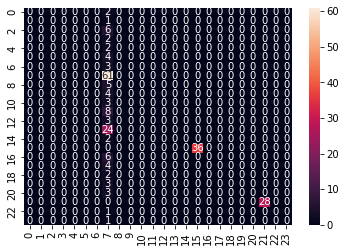

In [158]:
#1
#run the model on all_string - no changes to df

train = base_copy.sample(frac=0.8,random_state=seed) #random state is a seed value
test  = base_copy.drop(train.index)


nb_subject(test,train,train['Subject'],train['all_string'],test['Subject'],test['all_string']) 

accuracy is: 28.5% on test data

Balanced Accuracy: 0.041666666666666664


Recall - avg macro = 0.041666666666666664
Recall - avg micro = 0.2850467289719626
Recall - avg weighted = 0.2850467289719626


Precision - avg macro = 0.011876947040498442
Precision - avg micro = 0.2850467289719626
Precision - avg weighted = 0.0812516376976155


F1 - avg macro = 0.018484848484848482
F1 - avg micro = 0.2850467289719626
F1 - avg weighted = 0.12645709430756158


Predicted                 ENGLISH  All
True                                  
ACCOUNTING                      2    2
AGRICULTURE                     1    1
BUSINESS STUDIES                6    6
COMPUTER SCIENCE                2    2
DESIGN AND TECHNOLOGY           2    2
DRAMA                           4    4
ECONOMICS                       3    3
ENGLISH                        61   61
ENGLISH LITERARY STUDIES        5    5
FOOD TECHNOLOGY                 4    4
GEOGRAPHY                       3    3
HISTORY                         8    8


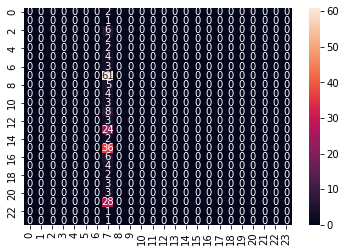

In [159]:
#2
#now do it on stemmed only
train = base_copy.sample(frac=0.8,random_state=seed) #random state is a seed value
test  = base_copy.drop(train.index)

nb_subject(test,train,train['Subject'],train['snow_stemmed'],test['Subject'],test['snow_stemmed']) 

accuracy is: 58.41% on test data

Balanced Accuracy: 0.125


Recall - avg macro = 0.125
Recall - avg micro = 0.5841121495327103
Recall - avg weighted = 0.5841121495327103


Precision - avg macro = 0.10027777777777779
Precision - avg micro = 0.5841121495327103
Precision - avg weighted = 0.41498442367601246


F1 - avg macro = 0.10742496050552923
F1 - avg micro = 0.5841121495327103
F1 - avg weighted = 0.46387916906586346


Predicted                 ENGLISH  MATHEMATICS  SCIENCE  All
True                                                        
ACCOUNTING                      2            0        0    2
AGRICULTURE                     1            0        0    1
BUSINESS STUDIES                6            0        0    6
COMPUTER SCIENCE                2            0        0    2
DESIGN AND TECHNOLOGY           2            0        0    2
DRAMA                           4            0        0    4
ECONOMICS                       3            0        0    3
ENGLISH                    

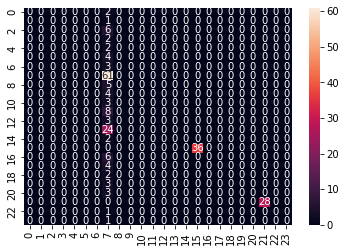

In [160]:
#3
#now lemmatised only
nb_subject(test,train,train['Subject'],train['lemmatised'],test['Subject'],test['lemmatised']) 

accuracy is: 28.5% on test data

Balanced Accuracy: 0.041666666666666664


Recall - avg macro = 0.041666666666666664
Recall - avg micro = 0.2850467289719626
Recall - avg weighted = 0.2850467289719626


Precision - avg macro = 0.011876947040498442
Precision - avg micro = 0.2850467289719626
Precision - avg weighted = 0.0812516376976155


F1 - avg macro = 0.018484848484848482
F1 - avg micro = 0.2850467289719626
F1 - avg weighted = 0.12645709430756158


Predicted                 ENGLISH  All
True                                  
ACCOUNTING                      2    2
AGRICULTURE                     1    1
BUSINESS STUDIES                6    6
COMPUTER SCIENCE                2    2
DESIGN AND TECHNOLOGY           2    2
DRAMA                           4    4
ECONOMICS                       3    3
ENGLISH                        61   61
ENGLISH LITERARY STUDIES        5    5
FOOD TECHNOLOGY                 4    4
GEOGRAPHY                       3    3
HISTORY                         8    8


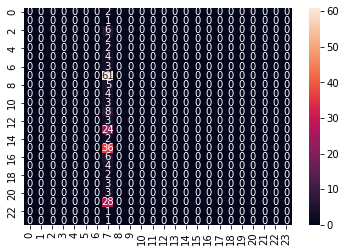

In [161]:
#4
nb_subject(test,train,train['Subject'],train['stem_lemm'],test['Subject'],test['stem_lemm']) 

accuracy is: 28.5% on test data

Balanced Accuracy: 0.041666666666666664


Recall - avg macro = 0.041666666666666664
Recall - avg micro = 0.2850467289719626
Recall - avg weighted = 0.2850467289719626


Precision - avg macro = 0.011876947040498442
Precision - avg micro = 0.2850467289719626
Precision - avg weighted = 0.0812516376976155


F1 - avg macro = 0.018484848484848482
F1 - avg micro = 0.2850467289719626
F1 - avg weighted = 0.12645709430756158


Predicted                 ENGLISH  All
True                                  
ACCOUNTING                      2    2
AGRICULTURE                     1    1
BUSINESS STUDIES                6    6
COMPUTER SCIENCE                2    2
DESIGN AND TECHNOLOGY           2    2
DRAMA                           4    4
ECONOMICS                       3    3
ENGLISH                        61   61
ENGLISH LITERARY STUDIES        5    5
FOOD TECHNOLOGY                 4    4
GEOGRAPHY                       3    3
HISTORY                         8    8


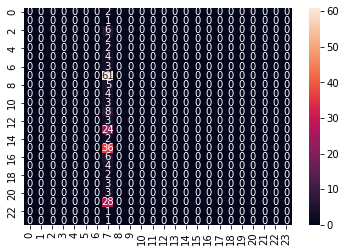

In [162]:
#5
nb_subject(test,train,train['Subject'],train['lemm_stem'],test['Subject'],test['lemm_stem']) 

accuracy is: 69.63% on test data

Balanced Accuracy: 0.16666666666666666


Recall - avg macro = 0.16666666666666666
Recall - avg micro = 0.6962616822429907
Recall - avg weighted = 0.6962616822429907


Precision - avg macro = 0.14517195767195767
Precision - avg micro = 0.6962616822429907
Precision - avg weighted = 0.5492137665034861


F1 - avg macro = 0.15218360071301248
F1 - avg micro = 0.6962616822429907
F1 - avg weighted = 0.5971812684292068


Predicted                 ENGLISH  LANGUAGES  MATHEMATICS  SCIENCE  All
True                                                                   
ACCOUNTING                      2          0            0        0    2
AGRICULTURE                     1          0            0        0    1
BUSINESS STUDIES                6          0            0        0    6
COMPUTER SCIENCE                2          0            0        0    2
DESIGN AND TECHNOLOGY           2          0            0        0    2
DRAMA                           4          0  

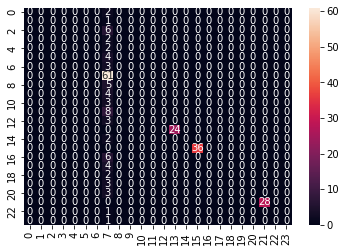

In [163]:
#6
#now nouns only
nb_subject(test,train,train['Subject'],train['noun'],test['Subject'],test['noun']) 

accuracy is: 58.41% on test data

Balanced Accuracy: 0.125


Recall - avg macro = 0.125
Recall - avg micro = 0.5841121495327103
Recall - avg weighted = 0.5841121495327103


Precision - avg macro = 0.10027777777777779
Precision - avg micro = 0.5841121495327103
Precision - avg weighted = 0.41498442367601246


F1 - avg macro = 0.10742496050552923
F1 - avg micro = 0.5841121495327103
F1 - avg weighted = 0.46387916906586346


Predicted                 ENGLISH  MATHEMATICS  SCIENCE  All
True                                                        
ACCOUNTING                      2            0        0    2
AGRICULTURE                     1            0        0    1
BUSINESS STUDIES                6            0        0    6
COMPUTER SCIENCE                2            0        0    2
DESIGN AND TECHNOLOGY           2            0        0    2
DRAMA                           4            0        0    4
ECONOMICS                       3            0        0    3
ENGLISH                    

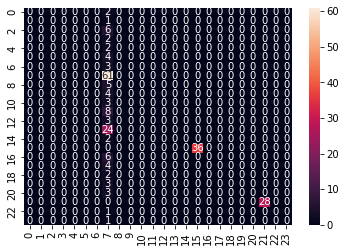

In [164]:
#7
nb_subject(test,train,train['Subject'],train['noun_lemm'],test['Subject'],test['noun_lemm']) 

accuracy is: 58.41% on test data

Balanced Accuracy: 0.125


Recall - avg macro = 0.125
Recall - avg micro = 0.5841121495327103
Recall - avg weighted = 0.5841121495327103


Precision - avg macro = 0.10027777777777779
Precision - avg micro = 0.5841121495327103
Precision - avg weighted = 0.41498442367601246


F1 - avg macro = 0.10742496050552923
F1 - avg micro = 0.5841121495327103
F1 - avg weighted = 0.46387916906586346


Predicted                 ENGLISH  MATHEMATICS  SCIENCE  All
True                                                        
ACCOUNTING                      2            0        0    2
AGRICULTURE                     1            0        0    1
BUSINESS STUDIES                6            0        0    6
COMPUTER SCIENCE                2            0        0    2
DESIGN AND TECHNOLOGY           2            0        0    2
DRAMA                           4            0        0    4
ECONOMICS                       3            0        0    3
ENGLISH                    

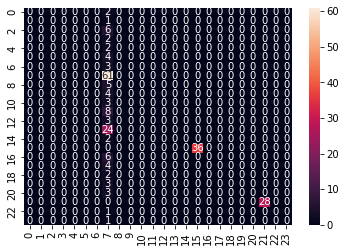

In [165]:
#8
nb_subject(test,train,train['Subject'],train['lemm_noun'],test['Subject'],test['lemm_noun']) 

accuracy is: 65.82% on test data

Balanced Accuracy: 0.21428571428571427


Recall - avg macro = 0.21428571428571427
Recall - avg micro = 0.6581632653061225
Recall - avg weighted = 0.6581632653061225


Precision - avg macro = 0.18010204081632653
Precision - avg micro = 0.6581632653061225
Precision - avg weighted = 0.47991982507288633


F1 - avg macro = 0.19181757209926226
F1 - avg micro = 0.6581632653061225
F1 - avg weighted = 0.5410079524767654


Predicted                 ENGLISH  MATHEMATICS  SCIENCE  All
True                                                        
ACCOUNTING                      1            0        0    1
BUSINESS STUDIES                4            0        0    4
DRAMA                           2            0        0    2
ENGLISH                        73            0        0   73
ENGLISH LITERARY STUDIES        5            0        0    5
HISTORY                         9            0        0    9
LANGUAGES                      27            0        0   27


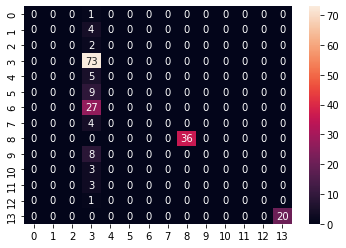

In [166]:
#9
#these subjects account for 53.3% of total subjects but only 7.32% of obs fall into these subjects
subj_excl1 = ['GEOGRAPHY','HUMANITIES','ECONOMICS','COMPUTER SCIENCE','DESIGN AND TECHNOLOGY',
             'FOOD TECHNOLOGY','VISUAL ARTS','ENVIRONMENTAL SCIENCE','POLITICS AND LAW','AGRICULTURE',
             'DANCE','MEDIA','PHILOSOPHY','ENGINEERING STUDIES','WORK STUDIES','HOME ECONOMICS']

clean_base1 = base_copy.loc[~base_copy['Subject'].isin(subj_excl1)]
train = clean_base1.sample(frac=0.8,random_state=seed) #seed value = 800
test  = clean_base1.drop(train.index)

nb_subject(test,train,train['Subject'],train['all_string'],test['Subject'],test['all_string']) 

accuracy is: 79.59% on test data

Balanced Accuracy: 0.2857142857142857


Recall - avg macro = 0.2857142857142857
Recall - avg micro = 0.7959183673469388
Recall - avg weighted = 0.7959183673469388


Precision - avg macro = 0.2604298356510746
Precision - avg micro = 0.7959183673469388
Precision - avg weighted = 0.6640780205887665


F1 - avg macro = 0.27035330261136714
F1 - avg micro = 0.7959183673469388
F1 - avg weighted = 0.7158218125960062


Predicted                 ENGLISH  LANGUAGES  MATHEMATICS  SCIENCE  All
True                                                                   
ACCOUNTING                      1          0            0        0    1
BUSINESS STUDIES                4          0            0        0    4
DRAMA                           2          0            0        0    2
ENGLISH                        73          0            0        0   73
ENGLISH LITERARY STUDIES        5          0            0        0    5
HISTORY                         9          0     

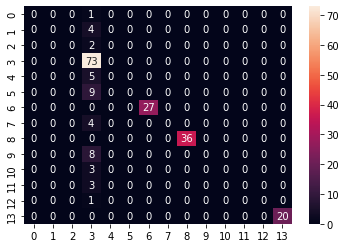

In [167]:
#9a
#these subjects account for 53.3% of total subjects but only 7.32% of obs fall into these subjects
subj_excl1 = ['GEOGRAPHY','HUMANITIES','ECONOMICS','COMPUTER SCIENCE','DESIGN AND TECHNOLOGY',
             'FOOD TECHNOLOGY','VISUAL ARTS','ENVIRONMENTAL SCIENCE','POLITICS AND LAW','AGRICULTURE',
             'DANCE','MEDIA','PHILOSOPHY','ENGINEERING STUDIES','WORK STUDIES','HOME ECONOMICS']

clean_base1 = base_copy.loc[~base_copy['Subject'].isin(subj_excl1)]
train = clean_base1.sample(frac=0.8,random_state=seed) #seed value = 800
test  = clean_base1.drop(train.index)

nb_subject(test,train,train['Subject'],train['noun'],test['Subject'],test['noun']) 

In [168]:
print(train['Subject'].unique())

['ENGLISH' 'ENGLISH LITERARY STUDIES' 'LANGUAGES' 'MATHEMATICS'
 'RELIGIOUS EDUCATION' 'PSYCHOLOGY' 'LEGAL STUDIES' 'DRAMA' 'HISTORY'
 'ACCOUNTING' 'SCIENCE' 'MUSIC' 'BUSINESS STUDIES' 'PDHPE']


accuracy is: 100.0% on test data

Balanced Accuracy: 1.0


Recall - avg macro = 1.0
Recall - avg micro = 1.0
Recall - avg weighted = 1.0


Precision - avg macro = 1.0
Precision - avg micro = 1.0
Precision - avg weighted = 1.0


F1 - avg macro = 1.0
F1 - avg micro = 1.0
F1 - avg weighted = 1.0


Predicted    ENGLISH  MATHEMATICS  SCIENCE  All
True                                           
ENGLISH           73            0        0   73
MATHEMATICS        0           27        0   27
SCIENCE            0            0       22   22
All               73           27       22  122


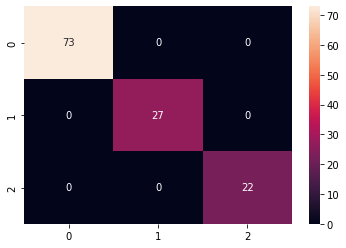

In [169]:
#10
subj_incl1 = ['ENGLISH','MATHEMATICS','SCIENCE']
clean_base2 = base_copy.loc[base_copy['Subject'].isin(subj_incl1)]

train = clean_base2.sample(frac=0.8,random_state=seed) #random state is a seed value
test  = clean_base2.drop(train.index)

nb_subject(test,train,train['Subject'],train['all_string'],test['Subject'],test['all_string']) 

# CONTENT-BASED RECOMMENDER SYSTEM

In [170]:
# ngram_range = 1-3 meaning bigrams, bigrams, trigrams
# turns target variable (all_string) into list of lists of 1,2,and 3 words
# e.g. "the blue cat smiled" becomes ["the","blue","cat","smiled"] // ["the blue","blue cat","cat smiled" etc]
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

tfidf_mat = tf.fit_transform(base["all_string"])

#sample of features
tf.get_feature_names_out()[5000:5010]

#now produce similarity score
#different options available: manhattan, euclidean, Pearson, cosine similarity 
#will start with cosine similarity 
#euclidean is inappropriate due to high dimensionality of dataset ('curse of dimensionality')
cosine_sim = cosine_similarity(tfidf_mat,tfidf_mat)
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_mat, tfidf_mat)

#now assign index to lookup the isbns
assgnd_index = pd.Series(base.index, index=base['ISBN'])

In [171]:
tf

TfidfVectorizer(min_df=0, ngram_range=(1, 3), stop_words='english')

In [172]:
def recommend_book(ISBN, cosine_sim=cosine_sim):
#    https://www.kaggle.com/code/shawamar/movie-recommendation-system/notebook
    # Get the index of the movie that matches the title
    idx = assgnd_index[ISBN]
    #print(idx)
    # Get the pairwsie similarity scores of all books compared with the selected book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the books indices
    book_index = [i[0] for i in sim_scores]
    
    #testprint = pd.DataFrame({'episode':[42, 21], 'frame':[4242,4248], 'item':[20,563]})
#     df['filename']=df.apply(lambda x: f"e{x.episode:03}_f{x.frame:05}_i{x['item']:05}.jpg", axis=1)
#     print (df)    

    #book = base["ISBN"].apply(lambda x: f'ISBN is {x}')
    #title = base["g_title"].apply(lambda x: f'{x}')
    #print(book,title)
    
    #testdesc = base.apply(lambda x: f"{x['ISBN']}  {x['g_title']}", axis=1)
    #print(testdesc)
    # Return the top 10 most similar movies
    #print(f"'ISBN: '{base['ISBN']}")
    #out_title = base["g_title"].apply(lambda x: f'Title {g_title}')
    #out_isbn = base["ISBN"].apply(lambda x: f'{g_title}{15}')
    #print(f'{out_title}{out_isbn}')
    #out = [f'ISBN: {ISBN}' for i in base["ISBN"]]
    #print(base['ISBN'].iloc[book_index])
#'{:15}'.format('{}'.format([1,2,3]))
    print(base['ISBN'].iloc[book_index] + " -- " + base['g_title'].iloc[book_index] + " || "+base['t_title'].iloc[book_index] )



In [173]:
recommend_book('9780980874921') # "Software Design & Development"

341    9780170411820 -- digital technologies australian curricu...
243    9780170411813 -- digital technologies australian curricu...
780    9780855837716 -- nsw biology || nsw biology module hered...
931    9780170365505 -- society culture preliminary hsc || soci...
914            9781108448079 --  || cambridgemaths stage gk powers
944            9781108434638 --  || cambridgemaths stage gk powers
950    9780170413220 --  || maths focus mathematics advanced ma...
692    9781922034717 -- extension mathematics || extension math...
892    9780957742888 -- new advanced mathematics || new advance...
781    9780855837723 -- nsw biology || nsw biology module infec...
dtype: string


### now repeat the above but use only nouns

In [174]:
# ngram_range = 1-3 meaning bigrams, bigrams, trigrams
# turns target variable (all_string) into list of lists of 1,2,and 3 words
# e.g. "the blue cat smiled" becomes ["the","blue","cat","smiled"] // ["the blue","blue cat","cat smiled" etc]
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

tfidf_mat2 = tf.fit_transform(base["noun"])

#sample of features
tf.get_feature_names_out()[5000:5010]

#now produce similarity score
#different options available: manhattan, euclidean, Pearson, cosine similarity 
#will start with cosine similarity 
#euclidean is inappropriate due to high dimensionality of dataset ('curse of dimensionality')
cosine_sim2 = cosine_similarity(tfidf_mat2,tfidf_mat2)
from sklearn.metrics.pairwise import linear_kernel
cosine_sim2 = linear_kernel(tfidf_mat2, tfidf_mat2)

#now assign index to lookup the isbns
assgnd_index2 = pd.Series(base.index, index=base['ISBN'])

In [175]:
def recommend_book_nouns(ISBN, cosine_sim=cosine_sim):
#    https://www.kaggle.com/code/shawamar/movie-recommendation-system/notebook
    # Get the index of the movie that matches the title
    idx2 = assgnd_index2[ISBN]
    #print(idx)
    # Get the pairwsie similarity scores of all books compared with the selected book
    sim_scores2 = list(enumerate(cosine_sim2[idx2]))

    # Sort the books based on the similarity scores
    sim_scores2 = sorted(sim_scores2, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores2 = sim_scores2[1:11]

    # Get the books indices
    book_index2 = [i[0] for i in sim_scores2]
    
    print(base['ISBN'].iloc[book_index2] + " -- " + base['g_title'].iloc[book_index2] + " || "+base['t_title'].iloc[book_index2] )



In [176]:
pd.options.display.max_colwidth = 60

In [177]:
recc_isbn = '9780310709626'
print("Recommendations using variable 'noun':")
recommend_book_nouns(recc_isbn)

print("\n"+"Recommendations using variable 'all_string':")
recommend_book(recc_isbn)


Recommendations using variable 'noun':
9      9781741352795 -- writing time f queensland beginner's al...
130    9780141316253 -- boy overboard || boy overboard morris g...
257    9781785583575 -- blitz beginner theory book || blitz beg...
98     9780224025720 -- matilda || matilda roald dahl illustrat...
331    9780199535064 -- complete short stories || complete shor...
33     9781741352801 -- writing time queensland beginner's alph...
123    9780670894383 -- game goose || game goose ursula dubosar...
180    9780141319001 -- girl underground || girl underground mo...
104                                9780849907685 -- holy bible || 
651    9781840222654 -- collected stories katherine mansfield |...
dtype: string

Recommendations using variable 'all_string':
528                               9780564098354 -- youth bible || 
298    9781599829234 -- catholic youth bible || catholic youth ...
104                                9780849907685 -- holy bible || 
556            9780970181671 -

In [178]:
#nouns only
recommend_book_nouns(recc_isbn) # "Beginners Bible"

9      9781741352795 -- writing time f queensland beginner's al...
130    9780141316253 -- boy overboard || boy overboard morris g...
257    9781785583575 -- blitz beginner theory book || blitz beg...
98     9780224025720 -- matilda || matilda roald dahl illustrat...
331    9780199535064 -- complete short stories || complete shor...
33     9781741352801 -- writing time queensland beginner's alph...
123    9780670894383 -- game goose || game goose ursula dubosar...
180    9780141319001 -- girl underground || girl underground mo...
104                                9780849907685 -- holy bible || 
651    9781840222654 -- collected stories katherine mansfield |...
dtype: string


In [179]:
#'raw' all_string
recommend_book(recc_isbn) # "Beginners Bible"

528                               9780564098354 -- youth bible || 
298    9781599829234 -- catholic youth bible || catholic youth ...
104                                9780849907685 -- holy bible || 
556            9780970181671 -- heart wisdom teaching approach || 
288    9781599822211 -- breakthrough bible old testament activi...
63                          9781400316908 -- first study bible || 
130    9780141316253 -- boy overboard || boy overboard morris g...
151    9780061441714 -- nrsv catholic edition || holy bible new...
47     9780142410394 -- twits || twits roald dahl illustrated q...
257    9781785583575 -- blitz beginner theory book || blitz beg...
dtype: string


In [180]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [181]:
# creating bag of words model
cv = CountVectorizer(max_features = 1500)
 
X = cv.fit_transform(base["all_string"]).toarray()
y = base.iloc[:, 1].values


# splitting the data set into training set and test set

 
X_train, X_test, y_train, y_test = train_test_split(
           X, y, test_size = 0.25, random_state = 0)

In [182]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
 
classifier = GaussianNB();
classifier.fit(X_train, y_train)
 
# predicting test set results
y_pred = classifier.predict(X_test)
 
# making the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 6,  6,  0,  2,  0,  2, 10,  2],
       [ 8, 29,  2,  0,  0,  5, 19,  2],
       [ 0,  2,  6,  2,  0,  0,  5,  0],
       [ 0,  6,  0, 11,  0,  3,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  1,  0,  1,  0,  0,  0,  0],
       [ 4, 16,  4,  3,  1,  8, 71,  3],
       [ 0,  1,  1,  0,  0,  0,  4, 16]], dtype=int64)

In [183]:
pd.options.display.max_colwidth = 250

In [184]:
testcase1 = base[base['ISBN']=='9781599829234']
#pd.options.display.max_colwidth = 90
print("Title: " + testcase1['g_title'] + " -- " + testcase1['Subject'])

testcase1['all_string']




298    Title: catholic youth bible -- RELIGIOUS EDUCATION
dtype: object


298    catholic youth bible new revised standard versioncatholic youth biblenew revised standard version catholic editionintroductions major sections bible books bible know insights church interpreted key scripture passages throughout history
Name: all_string, dtype: object

In [185]:
#======= ======= ======= ======= ======= ======= ======= ======= 
pd.options.display.max_colwidth = 150
testcase2 = base[base['ISBN']=='9780648237327']
print(testcase2['all_string'])
print(testcase2['snow_stemmed'])

1    kluwell home reading yellow levelsuitable lower primary students
Name: all_string, dtype: object
1    kluwel home read yellow levelsuit lower primari student
Name: snow_stemmed, dtype: object


In [186]:
#======= ======= ======= ======= ======= ======= ======= ======= 
pd.options.display.max_colwidth = 150
testcase3 = base[base['ISBN']=='9780310709626']
print("Provided Subject = " + testcase3['Subject'] + " -- Google Subject= "+ testcase3['g_title'] + "Trove Subj= " + testcase3['t_title'])
#print(testcase3['g_title'])
#print(testcase3['t_title'])

9781742152196

5    Provided Subject = ENGLISH -- Google Subject= beginner's bibleTrove Subj= beginner's bible
dtype: object


9781742152196

## VISUALISATIONS

In [187]:
#create variable to count number of words/length of desc in concat string
base['all_word_count'] = base["all_string"].apply(lambda x: len(str(x).split()))
base['all_word_len'] = base["all_string"].apply(lambda x: len(str(x)))

In [188]:
subject_count.plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Distribution of Total Characters for book descriptions')

NameError: name 'subject_count' is not defined

<AxesSubplot:title={'center':'Distribution of Total Characters for book descriptions'}, ylabel='Frequency'>

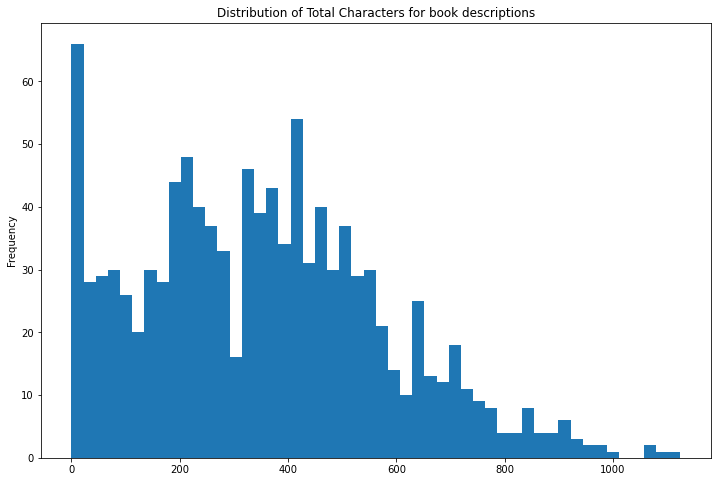

In [190]:
base['all_word_len'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Distribution of Total Characters for book descriptions')

<AxesSubplot:title={'center':'Word Count Distribution for book descriptions'}, ylabel='Frequency'>

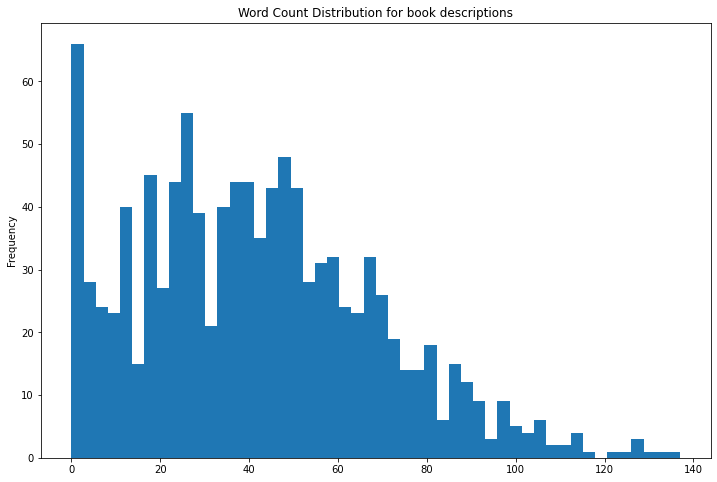

In [191]:
base['all_word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for book descriptions')

Text(0.5, 1.0, 'Count of books by subject')

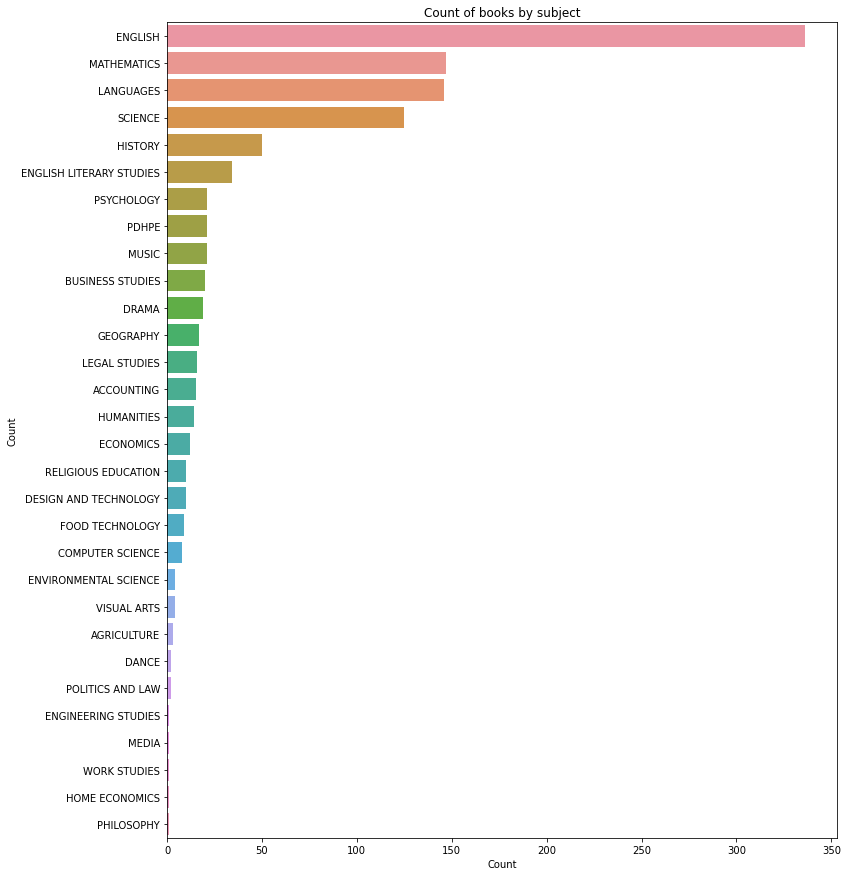

In [192]:
# get all subjects tags in a list
all_subjects = nltk.FreqDist(base['Subject'])

# create dataframe
all_genres_df = pd.DataFrame({'Subject': list(all_subjects.keys()), 
                              'Count': list(all_subjects.values())})

g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Subject") 
ax.set(ylabel = 'Count')
plt.title("Count of books by subject")

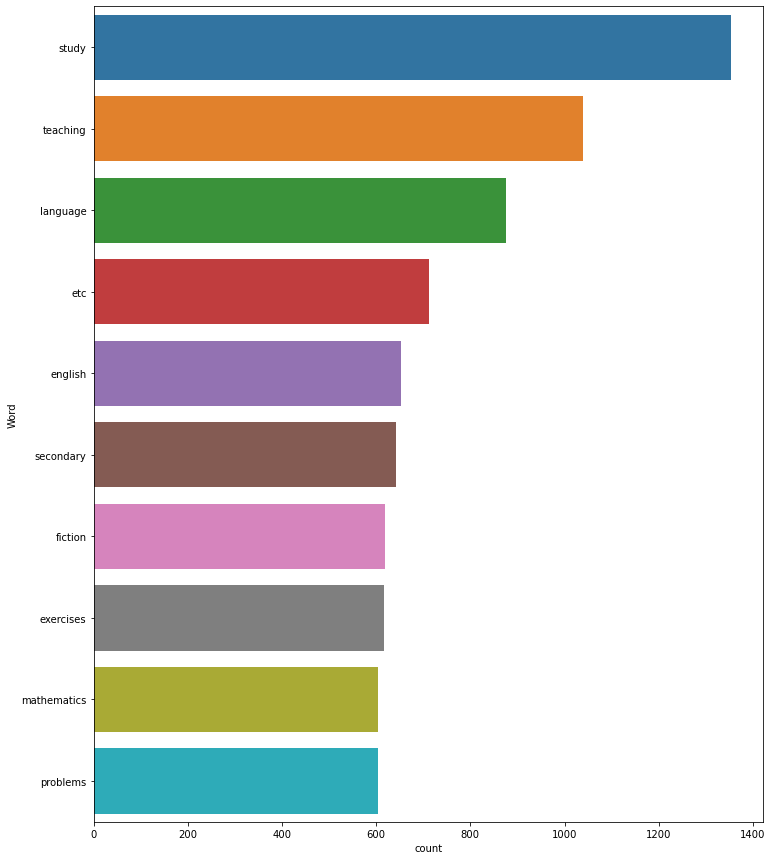

[Text(0.5, 17.200000000000003, 'x-label'), Text(17.200000000000003, 0.5, 'y-label')]


In [193]:
#https://towardsdatascience.com/topic-modeling-analysis-for-small-businesses-73ba23474261
def freq_words(x, terms): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    fig.suptitle('Sharing x per column, y per row')
    xx = ax.set(xlabel='x-label', ylabel='y-label')
    print(xx)

# print 100 most frequent words 
freq_words(base['all_string'], 10)
   



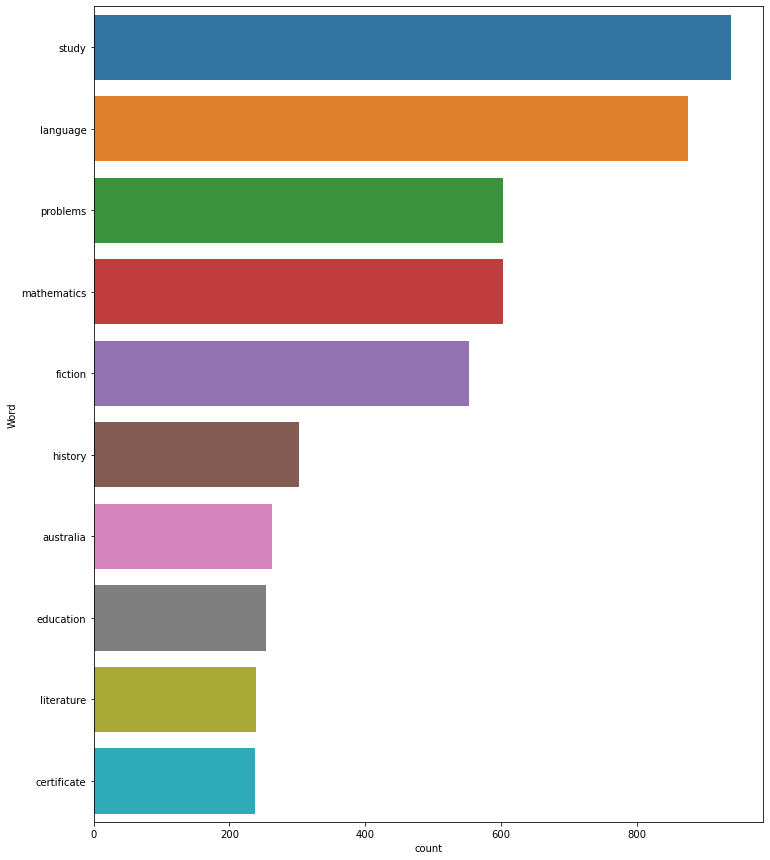

[Text(0.5, 17.200000000000003, 'x-label'), Text(17.200000000000003, 0.5, 'y-label')]


In [189]:
freq_words(base['noun'], 10) 

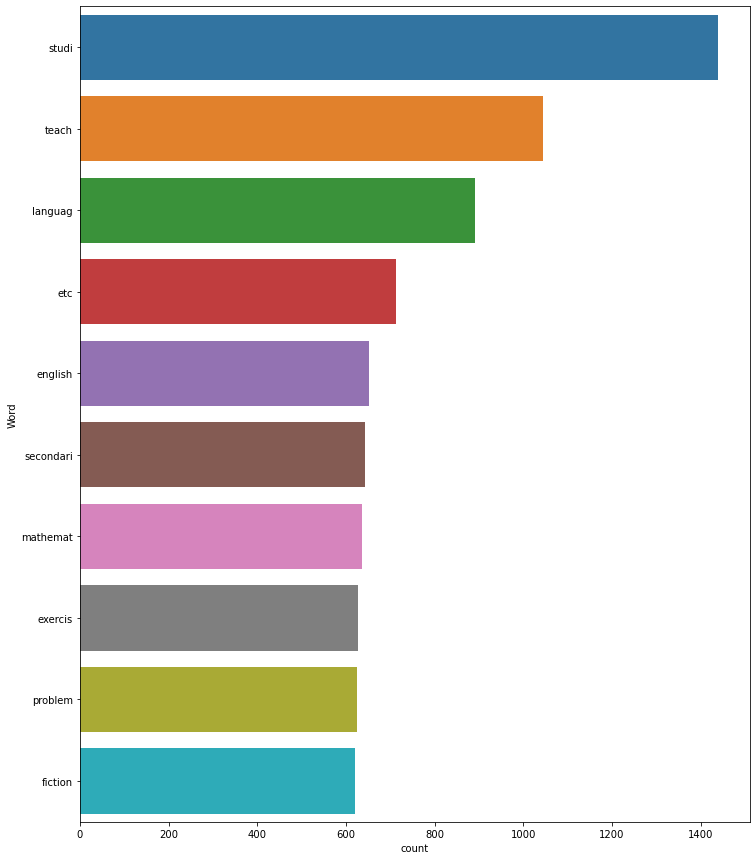

[Text(0.5, 17.200000000000003, 'x-label'), Text(17.200000000000003, 0.5, 'y-label')]


In [195]:
freq_words(base['snow_stemmed'], 10)

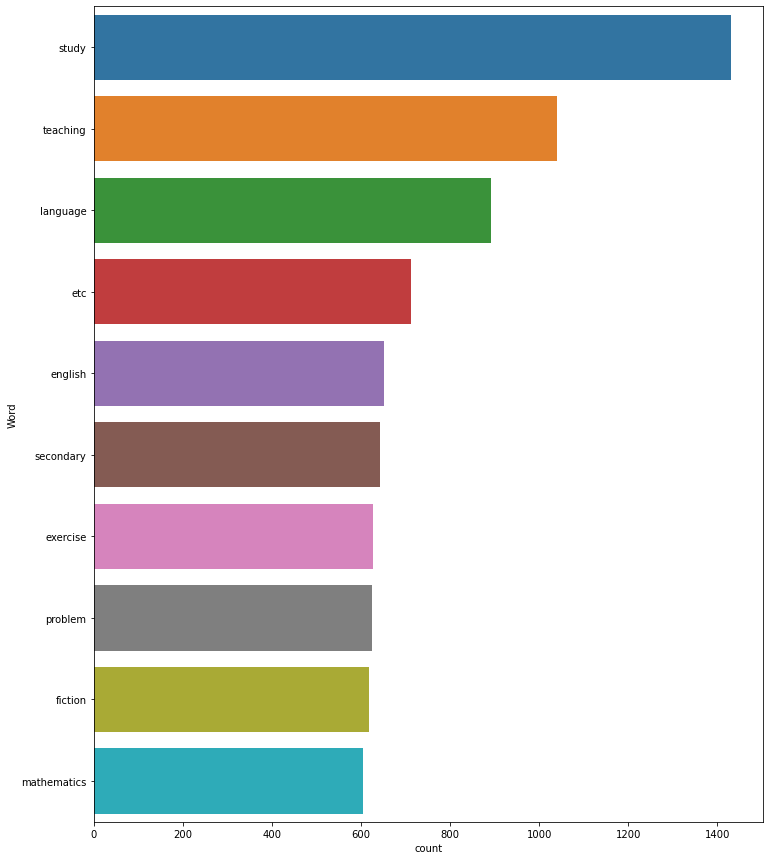

[Text(0.5, 17.200000000000003, 'x-label'), Text(17.200000000000003, 0.5, 'y-label')]


In [194]:
freq_words(base['lemmatised'], 10)